In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))


%matplotlib notebook
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy

pd.set_option('display.max_rows', 200)    


Using TensorFlow backend.
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cshul

# Raw data Paths
using Streamflow data direclty obtained from cshuler/ASPA-UH_Integrated_Modeling_Framework

In [2]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join(".", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

# read in data and convert to daily average values

<IPython.core.display.Javascript object>


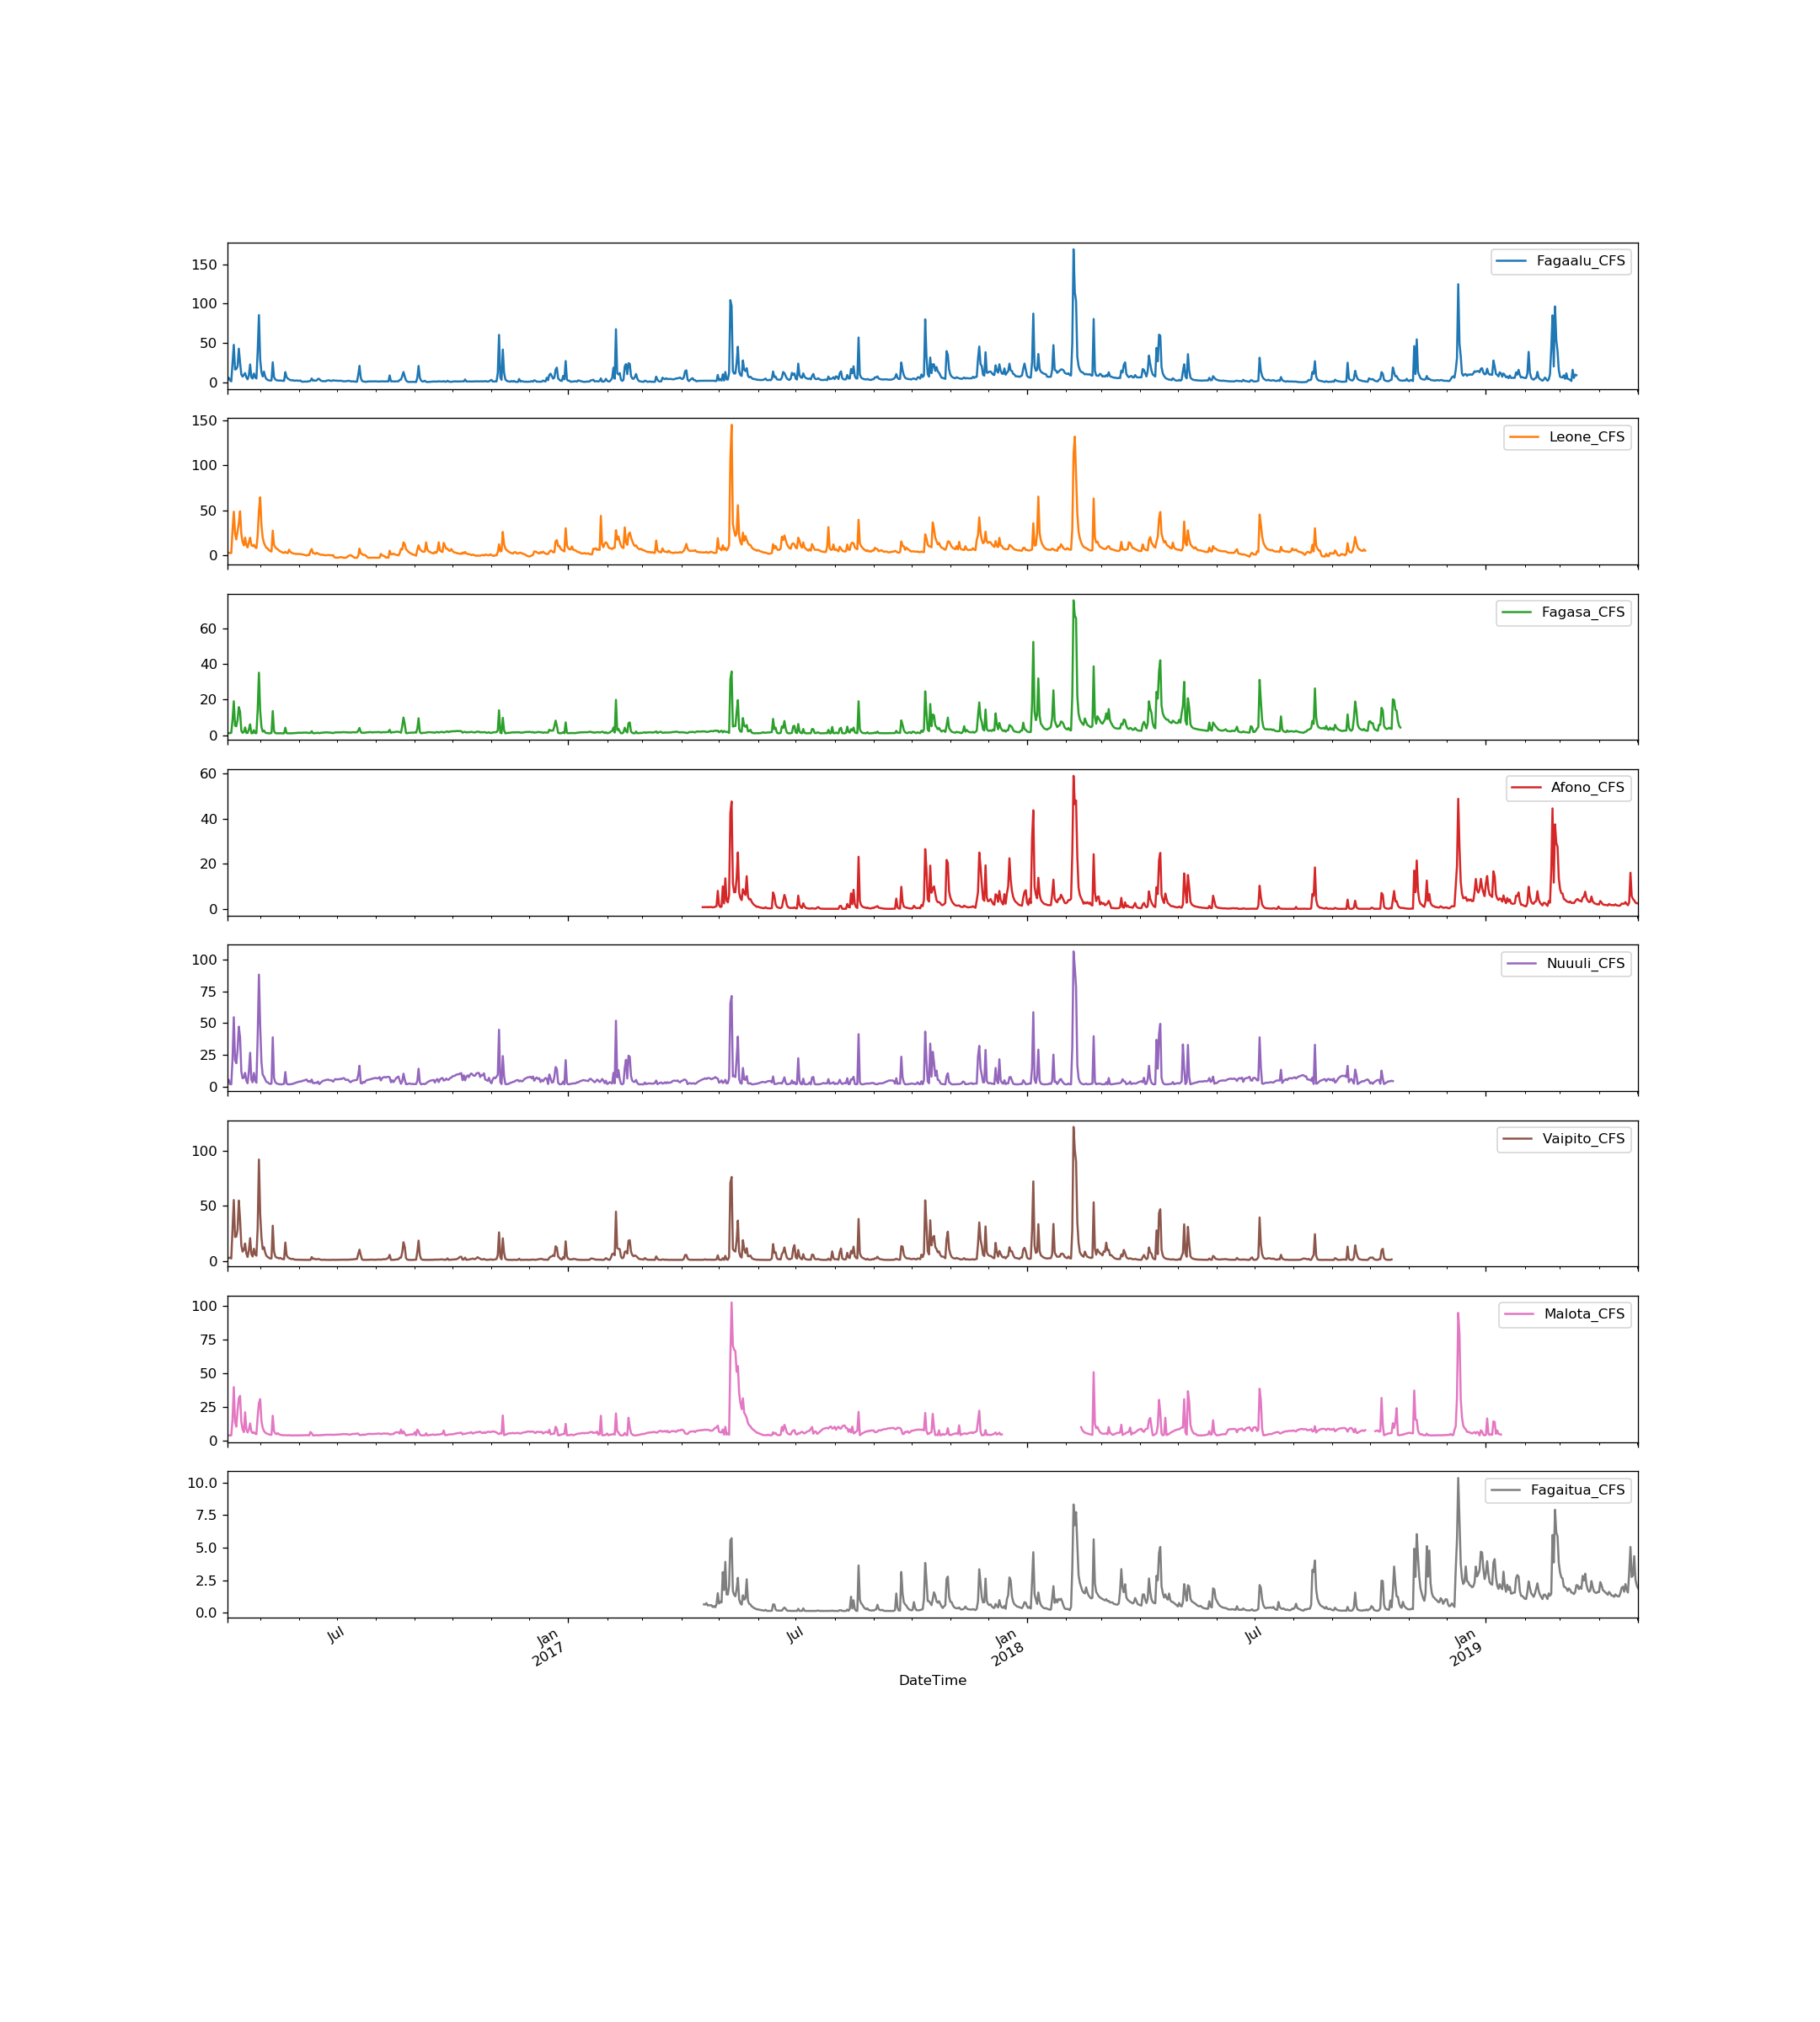

In [3]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[8:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 
    
data.plot(subplots=True, figsize=(18, 20)); plt.legend(loc='best')

# examine corelation matrix to see relationships between stations 

note that maloata station is poorly correlated, this is likey due to the station being messed up, so remove it. 


<IPython.core.display.Javascript object>


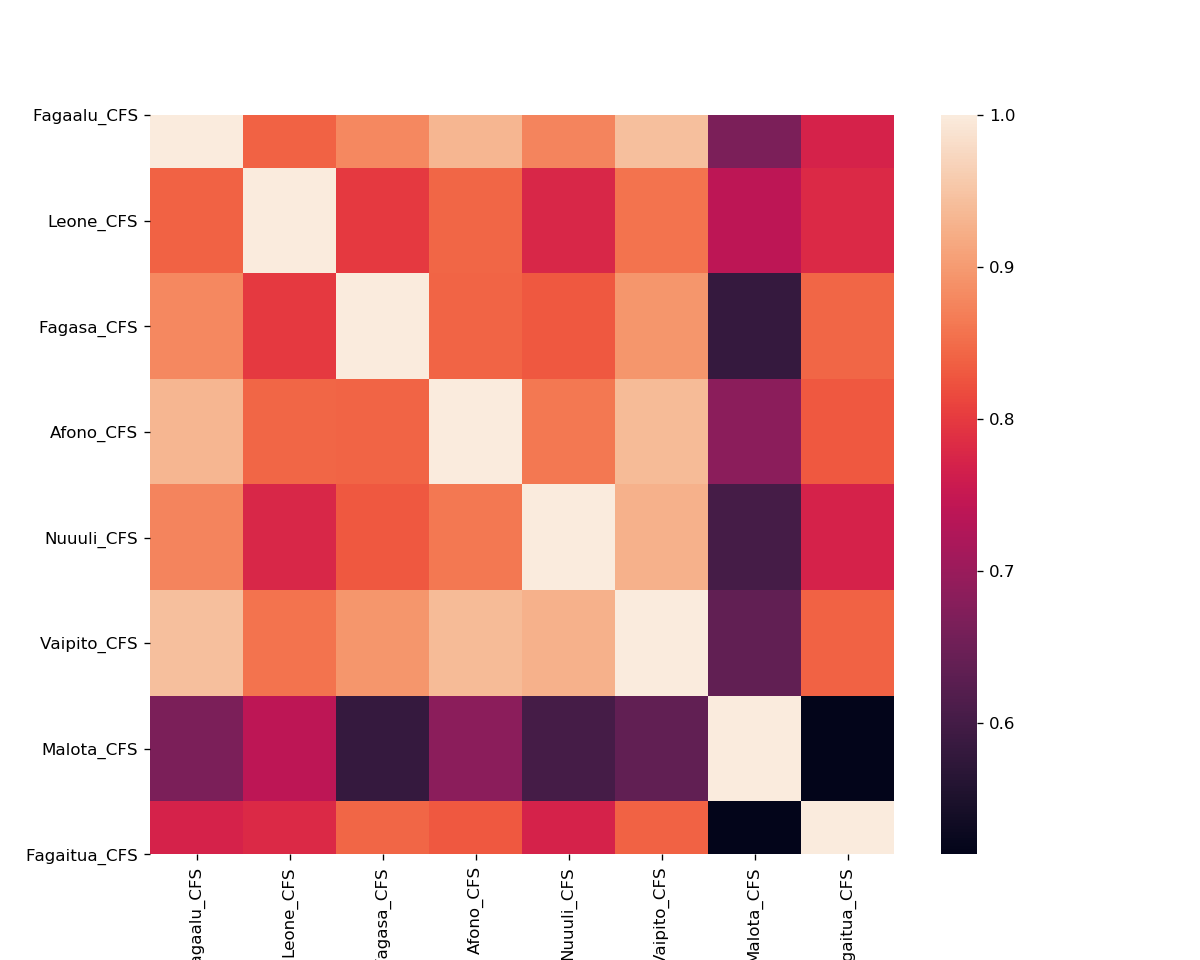

In [4]:
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

<IPython.core.display.Javascript object>


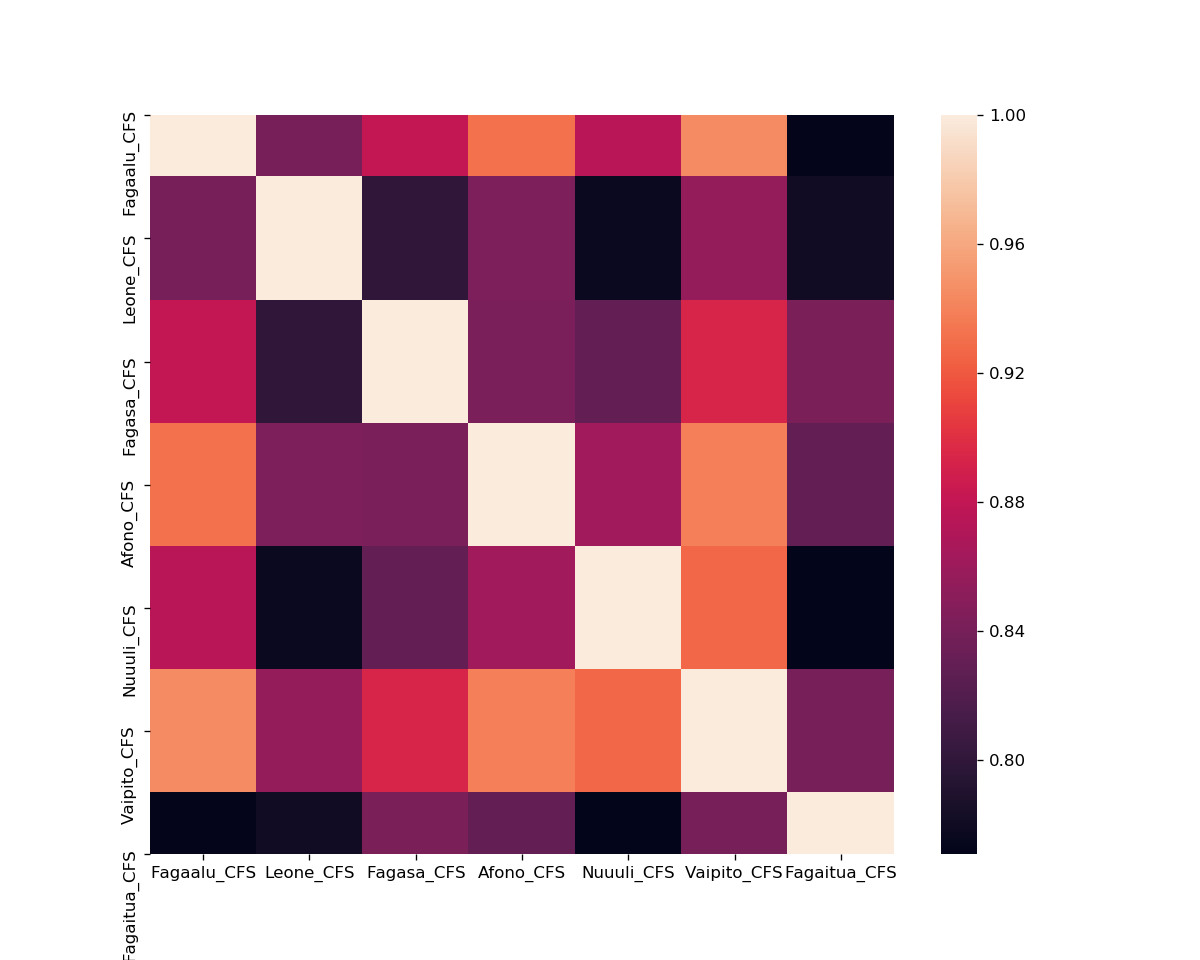

In [5]:
## remove Maloata from data  new plot
data = data.loc[:, data.columns != 'Malota_CFS']

plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

# Define what data ranges to use now

In [6]:
# some syntax....
print("First Date = {}".format(min(data.index)))
print("Last Date = {}".format(max(data.index)))
data.columns

First Date = 2016-04-05 00:00:00
Last Date = 2019-05-02 00:00:00


Index(['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS',
       'Vaipito_CFS', 'Fagaitua_CFS'],
      dtype='object')

In [7]:
#Definition of training sets
Train_Start = '2017-04-18'
Train_End = '2018-09-12'


X_train = data.loc[Train_Start:Train_End,['Nuuuli_CFS','Leone_CFS', 'Fagasa_CFS', 'Vaipito_CFS']].values   
y_train = data.loc[Train_Start:Train_End,'Afono_CFS'].values # Est 2

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# initilize the DL model 

In [8]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(4,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train the network
model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
model.fit(X_train, y_train,epochs=600, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/600
513/513 [==============================] - 0s 489us/step - loss: 41.9149 - acc: 0.0000e+00
Epoch 2/600
513/513 [==============================] - 0s 45us/step - loss: 10.6090 - acc: 0.0000e+00
Epoch 3/600
513/513 [==============================] - 0s 39us/step - loss: 7.9038 - acc: 0.0000e+00
Epoch 4/600
513/513 [==============================] - 0s 41us/step - loss: 6.7464 - acc: 0.0000e+00
Epoch 5/600
513/513 [==============================] - 0s 43us/step - loss: 6.2267 - acc: 0.0000e+00
Epoch 6/600
513/513 [==============================] - 0s 35us/step - loss: 5.6747 - acc: 0.0000e+00
Epoch 7/600
513/513 [==============================] - 0s 37us/step - loss: 5.4534 - acc: 0.0000e+00
Epoch 8/600
513/513 [==============================] - 0s 37us/step - loss: 5.2806 - acc: 0.0000e+00
Epoch 9/600
513/513 [==============================] - 0s 37us/step - loss: 5.3031 - acc: 0.0000e+00
Epoch 10/600
513/513 [==================

513/513 [==============================] - 0s 35us/step - loss: 3.8391 - acc: 0.0000e+00
Epoch 79/600
513/513 [==============================] - 0s 37us/step - loss: 3.9836 - acc: 0.0000e+00
Epoch 80/600
513/513 [==============================] - 0s 41us/step - loss: 3.8827 - acc: 0.0000e+00
Epoch 81/600
513/513 [==============================] - 0s 39us/step - loss: 7.1809 - acc: 0.0000e+00
Epoch 82/600
513/513 [==============================] - 0s 35us/step - loss: 3.9194 - acc: 0.0000e+00
Epoch 83/600
513/513 [==============================] - 0s 41us/step - loss: 3.8296 - acc: 0.0000e+00
Epoch 84/600
513/513 [==============================] - 0s 39us/step - loss: 3.9237 - acc: 0.0000e+00
Epoch 85/600
513/513 [==============================] - 0s 35us/step - loss: 3.8932 - acc: 0.0000e+00
Epoch 86/600
513/513 [==============================] - 0s 39us/step - loss: 3.9183 - acc: 0.0000e+00
Epoch 87/600
513/513 [==============================] - 0s 37us/step - loss: 3.7595 - acc: 0.00

513/513 [==============================] - 0s 43us/step - loss: 3.1399 - acc: 0.0000e+00
Epoch 158/600
513/513 [==============================] - 0s 39us/step - loss: 3.1641 - acc: 0.0000e+00
Epoch 159/600
513/513 [==============================] - 0s 35us/step - loss: 3.4738 - acc: 0.0000e+00
Epoch 160/600
513/513 [==============================] - 0s 39us/step - loss: 3.1720 - acc: 0.0000e+00
Epoch 161/600
513/513 [==============================] - 0s 39us/step - loss: 3.1369 - acc: 0.0000e+00
Epoch 162/600
513/513 [==============================] - 0s 35us/step - loss: 3.2867 - acc: 0.0000e+00
Epoch 163/600
513/513 [==============================] - 0s 43us/step - loss: 3.1070 - acc: 0.0000e+00
Epoch 164/600
513/513 [==============================] - 0s 39us/step - loss: 3.1780 - acc: 0.0000e+00
Epoch 165/600
513/513 [==============================] - 0s 33us/step - loss: 3.7687 - acc: 0.0000e+00
Epoch 166/600
513/513 [==============================] - 0s 39us/step - loss: 3.3415 - 

513/513 [==============================] - 0s 33us/step - loss: 2.8401 - acc: 0.0000e+00
Epoch 237/600
513/513 [==============================] - 0s 41us/step - loss: 2.8618 - acc: 0.0000e+00
Epoch 238/600
513/513 [==============================] - 0s 37us/step - loss: 3.3199 - acc: 0.0000e+00
Epoch 239/600
513/513 [==============================] - 0s 33us/step - loss: 3.0162 - acc: 0.0000e+00
Epoch 240/600
513/513 [==============================] - 0s 41us/step - loss: 4.0360 - acc: 0.0000e+00
Epoch 241/600
513/513 [==============================] - 0s 37us/step - loss: 3.0106 - acc: 0.0000e+00
Epoch 242/600
513/513 [==============================] - 0s 35us/step - loss: 2.8378 - acc: 0.0000e+00
Epoch 243/600
513/513 [==============================] - 0s 41us/step - loss: 2.8368 - acc: 0.0000e+00
Epoch 244/600
513/513 [==============================] - 0s 35us/step - loss: 2.8278 - acc: 0.0000e+00
Epoch 245/600
513/513 [==============================] - 0s 33us/step - loss: 2.7785 - 

513/513 [==============================] - 0s 41us/step - loss: 2.6747 - acc: 0.0000e+00
Epoch 316/600
513/513 [==============================] - 0s 37us/step - loss: 2.5691 - acc: 0.0000e+00
Epoch 317/600
513/513 [==============================] - 0s 39us/step - loss: 2.4958 - acc: 0.0000e+00
Epoch 318/600
513/513 [==============================] - 0s 39us/step - loss: 2.4925 - acc: 0.0000e+00
Epoch 319/600
513/513 [==============================] - 0s 35us/step - loss: 2.9305 - acc: 0.0000e+00
Epoch 320/600
513/513 [==============================] - 0s 41us/step - loss: 2.4598 - acc: 0.0000e+00
Epoch 321/600
513/513 [==============================] - 0s 45us/step - loss: 2.7038 - acc: 0.0000e+00
Epoch 322/600
513/513 [==============================] - 0s 33us/step - loss: 2.4342 - acc: 0.0000e+00
Epoch 323/600
513/513 [==============================] - 0s 39us/step - loss: 2.5360 - acc: 0.0000e+00
Epoch 324/600
513/513 [==============================] - 0s 41us/step - loss: 2.3096 - 

513/513 [==============================] - 0s 43us/step - loss: 2.0942 - acc: 0.0000e+00
Epoch 395/600
513/513 [==============================] - 0s 39us/step - loss: 1.9333 - acc: 0.0000e+00
Epoch 396/600
513/513 [==============================] - 0s 35us/step - loss: 2.0465 - acc: 0.0000e+00
Epoch 397/600
513/513 [==============================] - 0s 43us/step - loss: 1.9489 - acc: 0.0000e+00
Epoch 398/600
513/513 [==============================] - 0s 41us/step - loss: 2.0702 - acc: 0.0000e+00
Epoch 399/600
513/513 [==============================] - 0s 35us/step - loss: 2.0258 - acc: 0.0000e+00
Epoch 400/600
513/513 [==============================] - 0s 41us/step - loss: 2.0073 - acc: 0.0000e+00
Epoch 401/600
513/513 [==============================] - 0s 39us/step - loss: 1.9110 - acc: 0.0000e+00
Epoch 402/600
513/513 [==============================] - 0s 33us/step - loss: 1.9217 - acc: 0.0000e+00
Epoch 403/600
513/513 [==============================] - 0s 37us/step - loss: 1.9015 - 

513/513 [==============================] - 0s 39us/step - loss: 1.8744 - acc: 0.0000e+00
Epoch 474/600
513/513 [==============================] - 0s 41us/step - loss: 2.0204 - acc: 0.0000e+00
Epoch 475/600
513/513 [==============================] - 0s 35us/step - loss: 1.8534 - acc: 0.0000e+00
Epoch 476/600
513/513 [==============================] - 0s 37us/step - loss: 1.8565 - acc: 0.0000e+00
Epoch 477/600
513/513 [==============================] - 0s 41us/step - loss: 1.9654 - acc: 0.0000e+00
Epoch 478/600
513/513 [==============================] - 0s 35us/step - loss: 1.9804 - acc: 0.0000e+00
Epoch 479/600
513/513 [==============================] - 0s 37us/step - loss: 1.8724 - acc: 0.0000e+00
Epoch 480/600
513/513 [==============================] - 0s 39us/step - loss: 1.9398 - acc: 0.0000e+00
Epoch 481/600
513/513 [==============================] - 0s 37us/step - loss: 1.9094 - acc: 0.0000e+00
Epoch 482/600
513/513 [==============================] - 0s 33us/step - loss: 2.9597 - 

513/513 [==============================] - 0s 33us/step - loss: 2.4353 - acc: 0.0000e+00
Epoch 553/600
513/513 [==============================] - 0s 41us/step - loss: 2.4474 - acc: 0.0000e+00
Epoch 554/600
513/513 [==============================] - 0s 39us/step - loss: 1.7965 - acc: 0.0000e+00
Epoch 555/600
513/513 [==============================] - 0s 35us/step - loss: 1.7459 - acc: 0.0000e+00
Epoch 556/600
513/513 [==============================] - 0s 41us/step - loss: 1.9378 - acc: 0.0000e+00
Epoch 557/600
513/513 [==============================] - 0s 41us/step - loss: 2.7624 - acc: 0.0000e+00
Epoch 558/600
513/513 [==============================] - 0s 35us/step - loss: 1.9275 - acc: 0.0000e+00
Epoch 559/600
513/513 [==============================] - 0s 39us/step - loss: 1.8094 - acc: 0.0000e+00
Epoch 560/600
513/513 [==============================] - 0s 43us/step - loss: 1.7882 - acc: 0.0000e+00
Epoch 561/600
513/513 [==============================] - 0s 37us/step - loss: 1.6057 - 

<IPython.core.display.Javascript object>


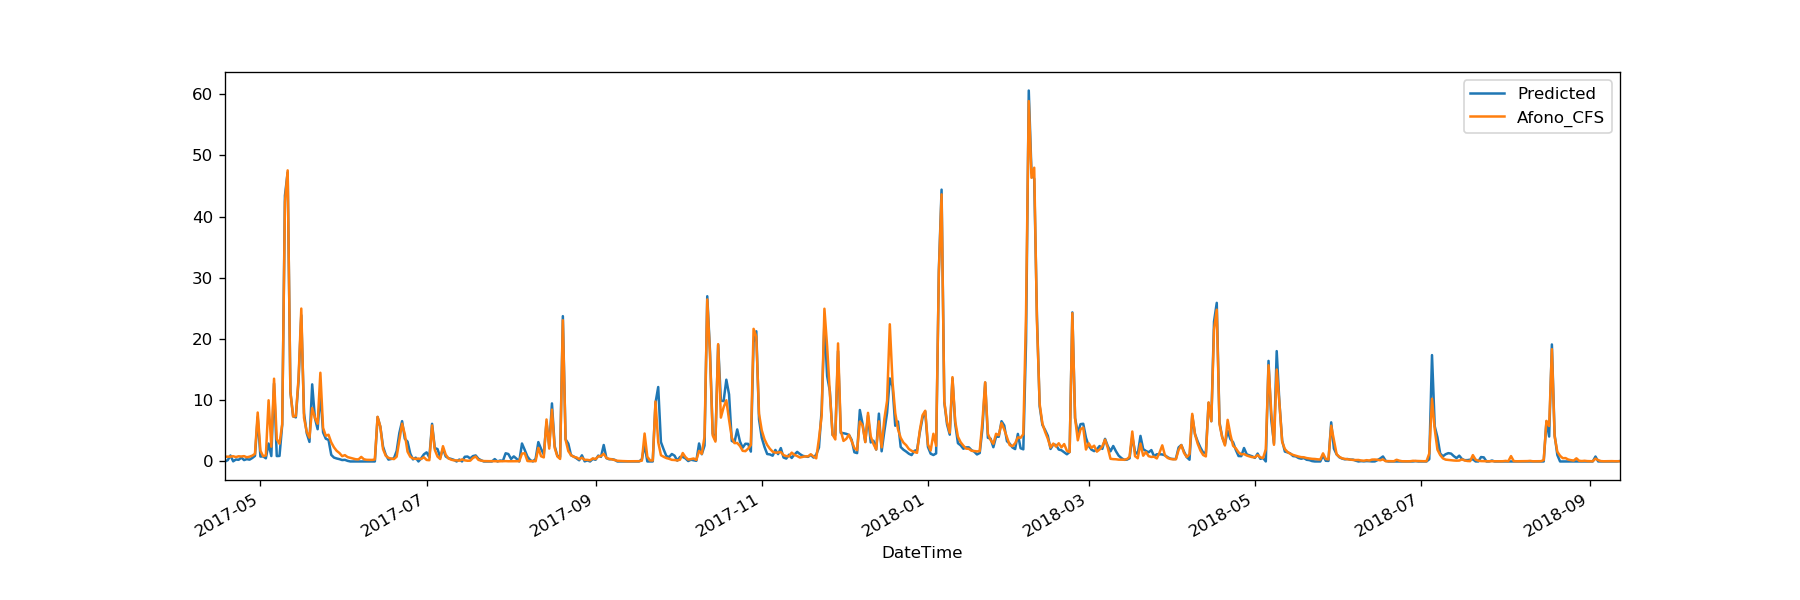

<IPython.core.display.Javascript object>


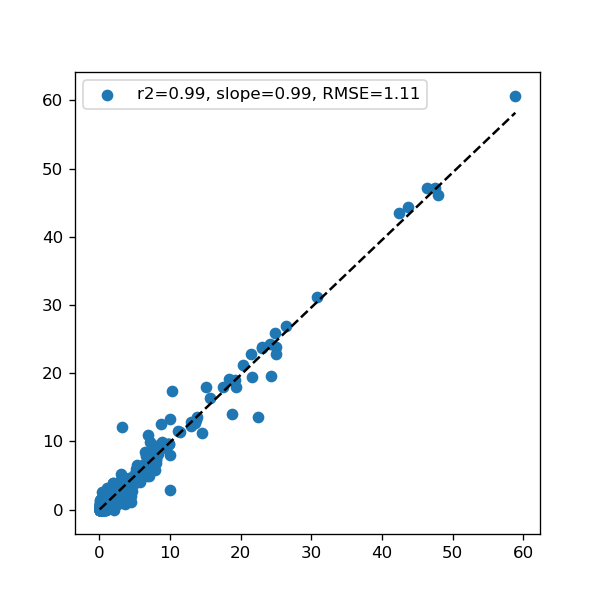

RMSE Error: 1.11
r2: 0.99
slope : 0.99


In [10]:
# plot time series
y_pred = model.predict(X_train)

fig1 = plt.figure(figsize=(15, 5))
plt.plot(data.loc[Train_Start:Train_End].index, y_pred,label='Predicted')
data['Afono_CFS'].loc[Train_Start:Train_End].plot()
plt.legend(loc='best')

# plot and analyze comparison
x = np.squeeze(data['Afono_CFS'].loc[Train_Start:Train_End].values)
y = np.squeeze(y_pred)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
mea = np.mean(np.abs(x-y)); rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error

fig2 = plt.figure(figsize=(5, 5))
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
plt.scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}, RMSE={2:1.2f}".format(r_value, slope, rmse))                                                                                       # plot dots
plt.legend()

print ('RMSE Error: {:.2f}\nr2: {:.2f}\nslope : {:.2f}'.format(rmse, r_value, slope ))

# predict missing data 

<IPython.core.display.Javascript object>


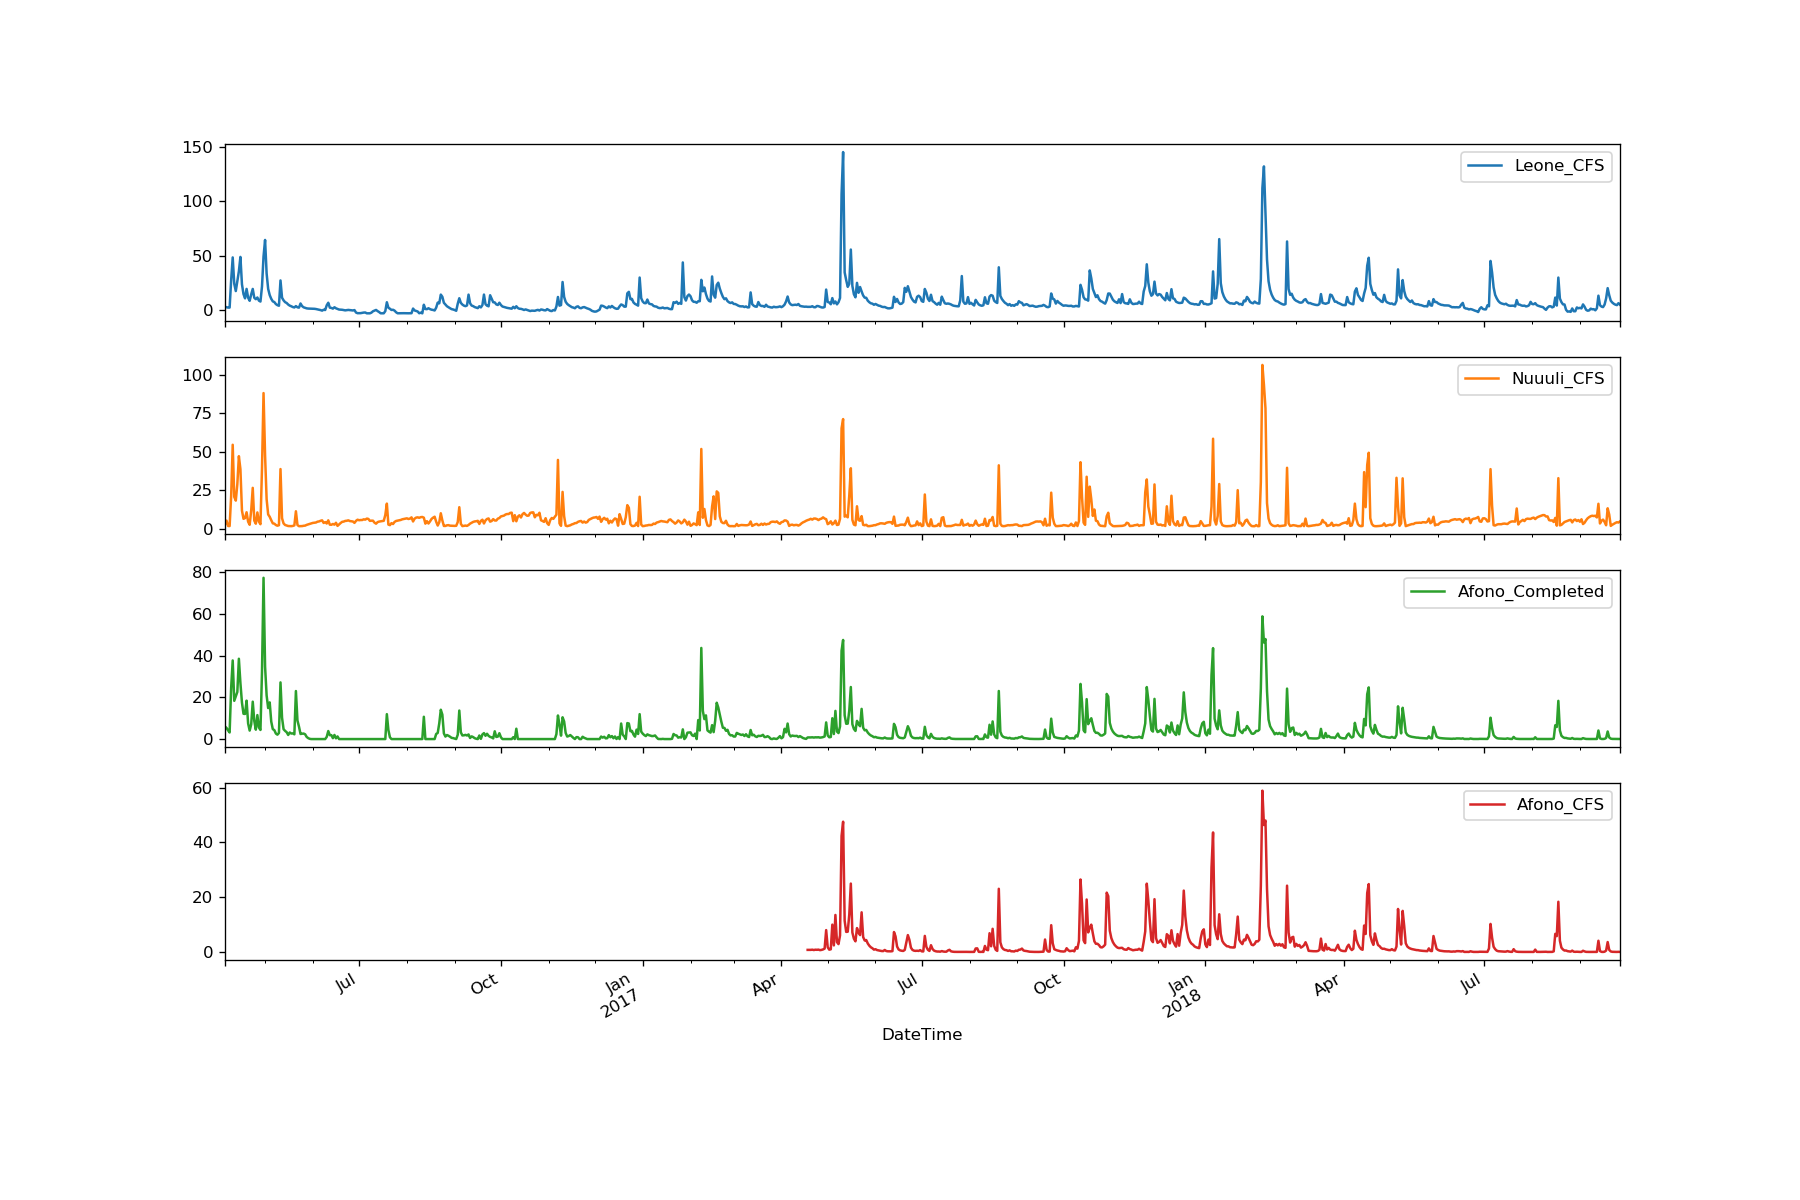

In [11]:


#Get the prediction for the train set
X_missing = data.loc['2016-04-5':'2017-04-17',['Nuuuli_CFS','Leone_CFS', 'Fagasa_CFS', 'Vaipito_CFS']].values   

# Define the scaler 
scaler = StandardScaler().fit(X_missing)

# Scale the train set
X_missing = scaler.transform(X_missing)



y_missing = model.predict(X_missing)
y_missing = y_missing.reshape([378]).tolist()


data['Afono_Completed']=data['Afono_CFS']
data['Afono_Completed'].loc['2016-04-5':'2017-04-17'] = y_missing

data.loc['2016-04-05':'2018-09-27',['Leone_CFS','Nuuuli_CFS','Afono_Completed','Afono_CFS']].plot(subplots=True,  figsize=(15, 10)); plt.legend(loc='best')


# Loop over all stations, train on half data, predict on other half then validate effectiveness of gap filling 

gap filling for station Fagaalu_CFS
Training with stations ['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


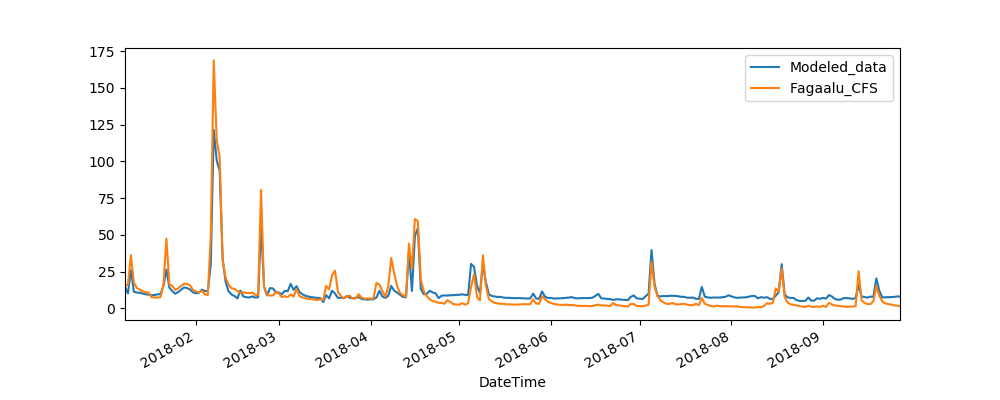

<IPython.core.display.Javascript object>


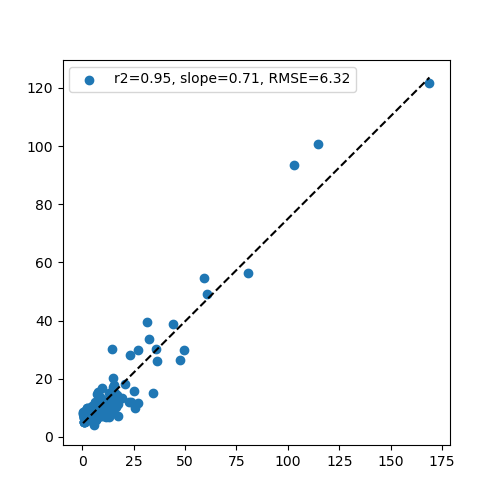

RMSE Error: 6.32
r2: 0.95
slope : 0.71
gap filling for station Leone_CFS
Training with stations ['Fagaalu_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


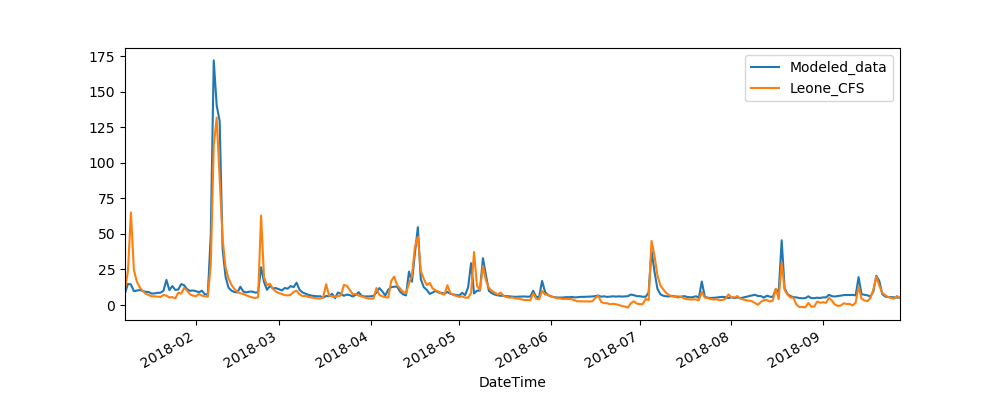

<IPython.core.display.Javascript object>


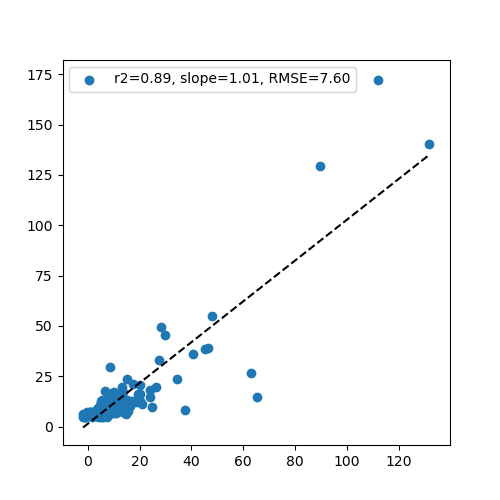

RMSE Error: 7.60
r2: 0.89
slope : 1.01
gap filling for station Fagasa_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


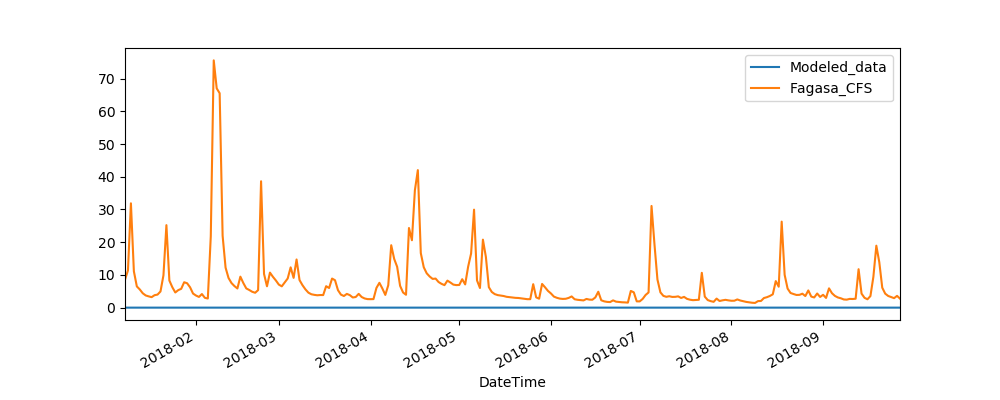

<IPython.core.display.Javascript object>


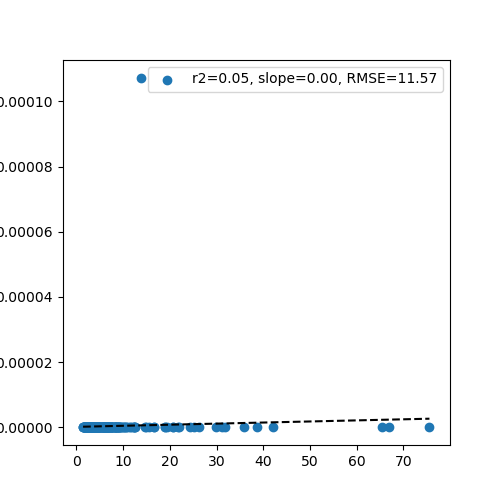

RMSE Error: 11.57
r2: 0.05
slope : 0.00
gap filling for station Afono_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


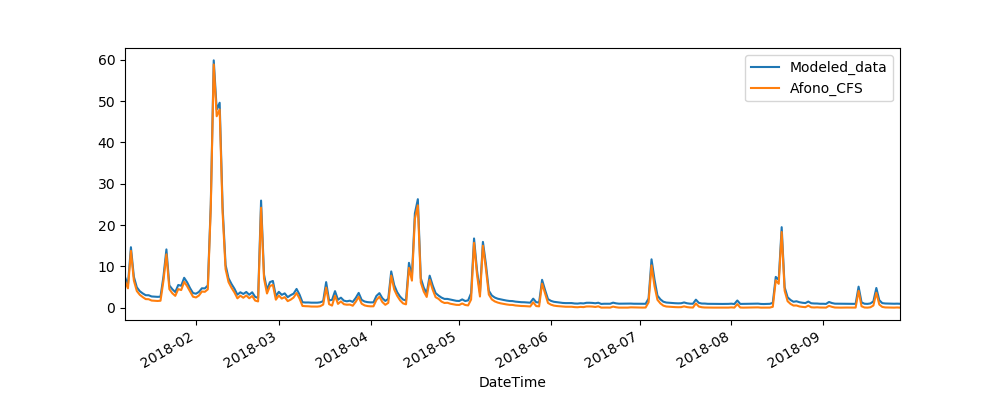

<IPython.core.display.Javascript object>


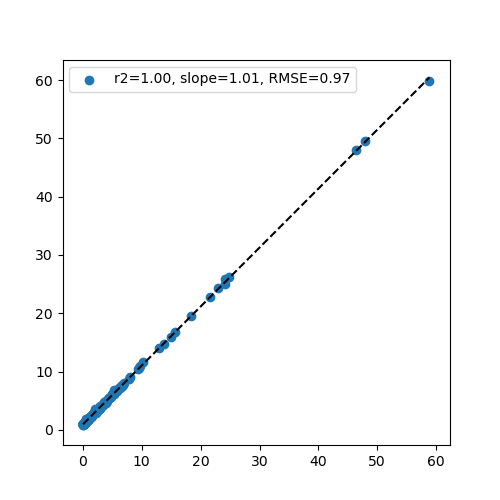

RMSE Error: 0.97
r2: 1.00
slope : 1.01
gap filling for station Nuuuli_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Vaipito_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


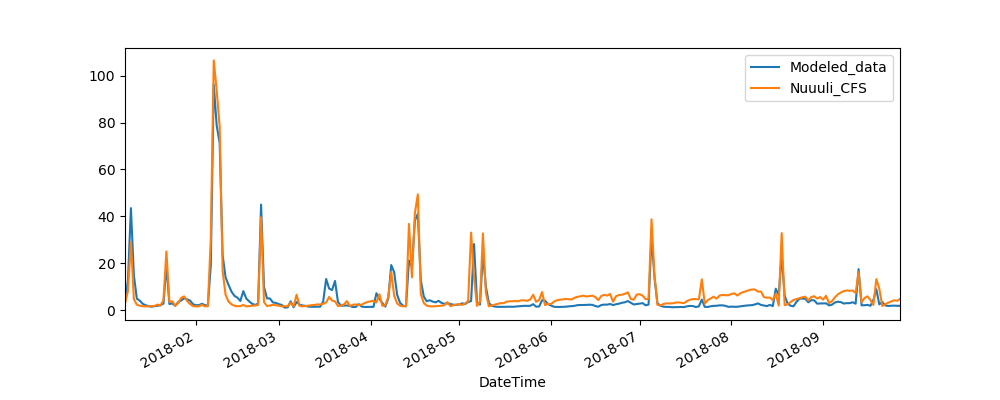

<IPython.core.display.Javascript object>


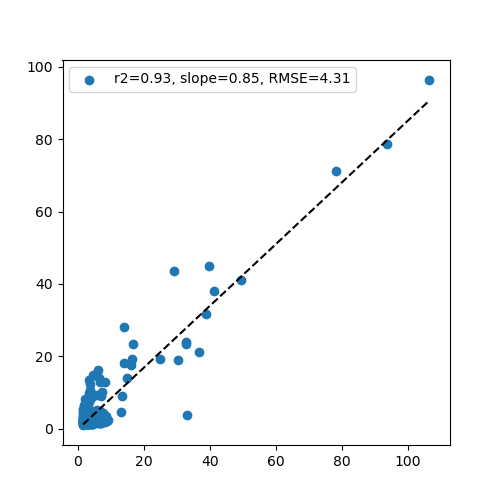

RMSE Error: 4.31
r2: 0.93
slope : 0.85
gap filling for station Vaipito_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Fagaitua_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


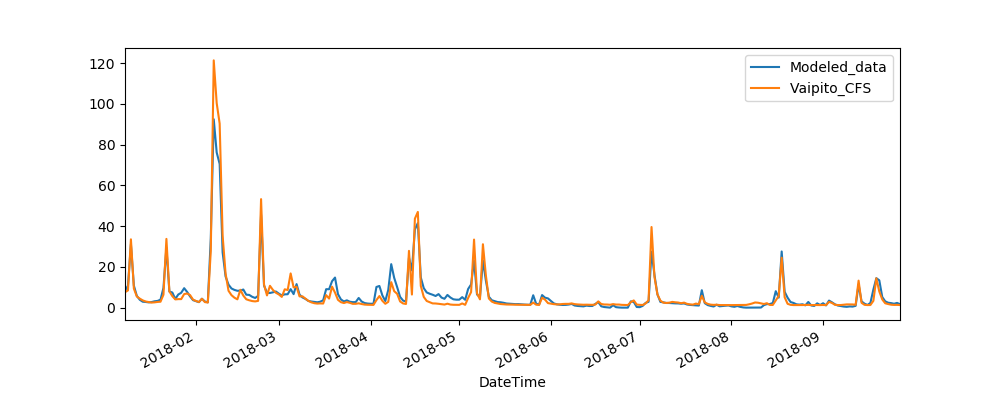

<IPython.core.display.Javascript object>


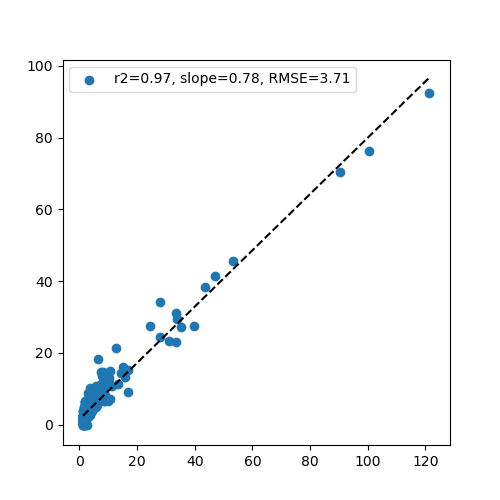

RMSE Error: 3.71
r2: 0.97
slope : 0.78
gap filling for station Fagaitua_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Afono_Completed']


<IPython.core.display.Javascript object>


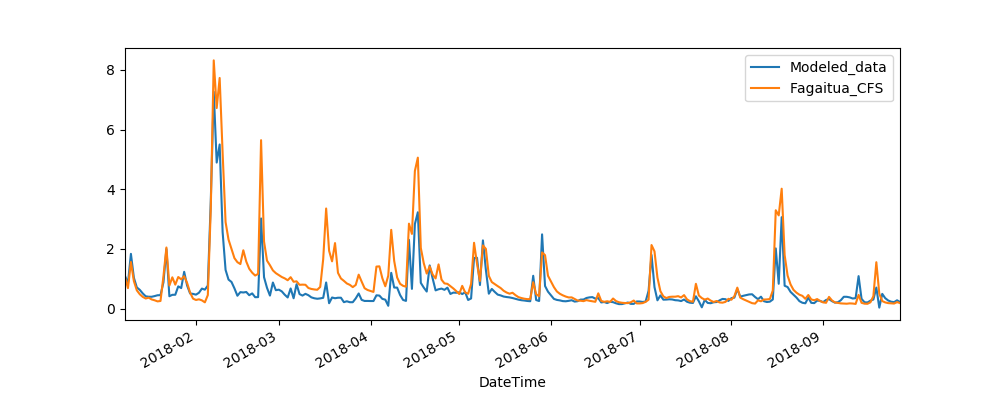

<IPython.core.display.Javascript object>


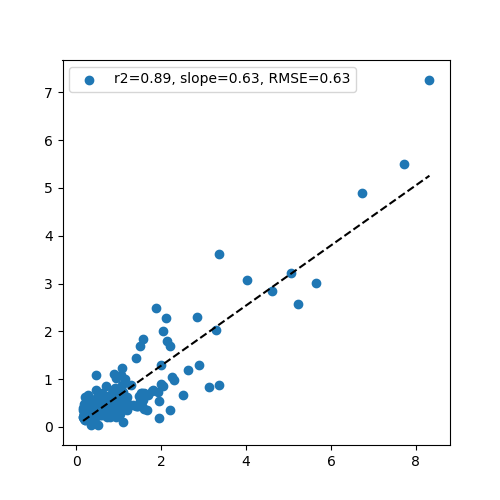

RMSE Error: 0.63
r2: 0.89
slope : 0.63
gap filling for station Afono_Completed
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


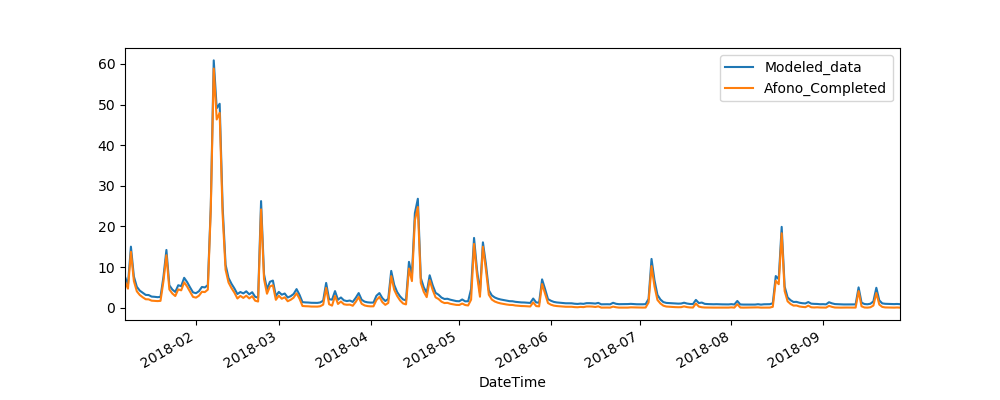

<IPython.core.display.Javascript object>


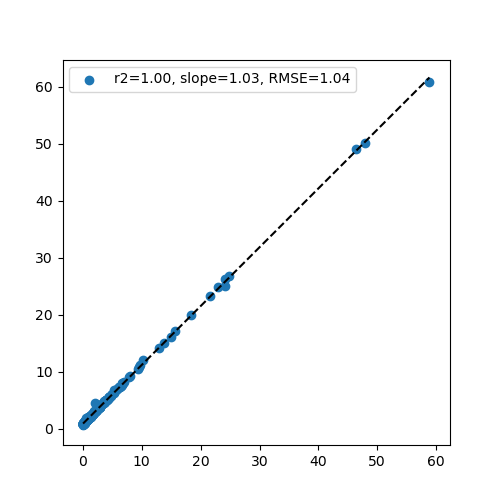

RMSE Error: 1.04
r2: 1.00
slope : 1.03
OVERALL RMSE = 4.517768527830741
OVERALL r2 = 0.836564319919864
OVERALL Slope = 0.753507274967354


In [85]:
# make sure that maloata is gone
data = data.loc[:, data.columns != 'Malota_CFS']

# just select perfect no gap dataset 
data_all = data.dropna()

plt.close("all")  # close previous figures to clear memory
station_list = list(data_all.columns)

RMSE_list=[]; slope_list=[];r2_list=[]

for i in station_list:
    trainlist = station_list.copy()                 # the list of all the other stations with which to use to train the network
    trainlist.remove(i)           
    print("gap filling for station {}".format(i))
    print("Training with stations {}".format(trainlist))
    
    # some math to be able to select a portion of the dataset, based upon a percentage (0-1)of the data we want to remove   ( can loop over how_much_to_delete variable later)
    n = len(data_all[i])
    how_much_to_delete = .5                       # Has to be   0 < x < 1  cant be 0 or 1. 
    stop_idx = n-int((how_much_to_delete)*n)
    Train_End = data_all.index[stop_idx]                # end of the training data period, i.e. training data omits data after this data 
    Train_Start = data_all.index[0]                      # start of the training data period (always the beginning of data all 
    
    X_train = data.loc[Train_Start:Train_End,trainlist].values   
    y_train = data.loc[Train_Start:Train_End,i].values  
    
    #scale values appropriately
    scaler = StandardScaler().fit(X_train)   # Define the scaler 
    X_train = scaler.transform(X_train) # Scale the train set
    
    model = Sequential()

    model.add(Dense(100, activation='relu', input_shape=(len(trainlist),)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='relu'))
    #model.summary()
    
    # train the network
    model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
    model.fit(X_train, y_train,epochs=200, verbose=0)
    
# now run the network on data not used for training to validate effacacy

    Predict_Start = data_all.index[(stop_idx)]                # Start of the validatiaon data period, = end of training data 
    Predict_End = data_all.index[-1]                      # end of the validation data period (always the end of data all)

    X_predict_known = data.loc[Predict_Start:Predict_End,trainlist].values 
    #scale values appropriately
    scaler = StandardScaler().fit(X_predict_known)   # Define the scaler 
    X_predict_known = scaler.transform(X_predict_known) # Scale the train set

    y_predict_unknown = model.predict(X_predict_known)
    y_predict_unknown = y_predict_unknown.reshape([np.shape(y_predict_unknown)[0]]).tolist()

    y_real_data = data[i].loc[Predict_Start:Predict_End].values

    x = np.squeeze(y_real_data)
    y = y_predict_unknown
    
# plot time series
    fig1 = plt.figure(figsize=(10, 4))
    plt.plot(data.loc[Predict_Start:Predict_End].index, y,label='Modeled_data')
    data[i].loc[Predict_Start:Predict_End].plot()
    plt.legend(loc='best')

# plot and analyze comparison
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
    mea = np.mean(np.abs(x-y)); rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error

    fig2 = plt.figure(figsize=(5, 5))
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
    plt.scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}, RMSE={2:1.2f}".format(r_value, slope, rmse))                                                                                       # plot dots
    plt.legend()
    
    RMSE_list.append(rmse); slope_list.append(slope);r2_list.append(r_value)

    print ('RMSE Error: {:.2f}\nr2: {:.2f}\nslope : {:.2f}'.format(rmse, r_value, slope ))

print("OVERALL RMSE = {}\nOVERALL r2 = {}\nOVERALL Slope = {}".format(np.mean(RMSE_list), np.mean(r2_list), np.mean(slope_list)))

In [84]:

    model.add(Dense(100, activation='relu', input_shape=(len(trainlist),)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='relu'))
    #model.summary()
    
    # train the network
    model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
    model.fit(X_train, y_train,epochs=10, verbose=0)
    
    

print("OVERALL RMSE = {}\nOVERALL r2 = {}\nOVERALL Slope = {}".format(np.mean(RMSE_list), np.mean(r2_list), np.mean(slope_list)))

OVERALL RMSE = 3.4917003547817953
OVERALL r2 = 0.957968322048498
OVERALL Slope = 0.791582667396961


In [ ]:
set up validataion test: 
process: 
1) make data all perfect no gap dataset. 
2) for each column (site) 
   2.1 select 5% of data, and remove 
   2.2 use remaining coluns with the existing data in the selected column as training data 
   2.3 train the network (that is the same as the model being used in the script) 


In [ ]:
goal for next: 
    figure out how to use multivariate data, (such as topography, or rainfall, soil, and land use) to predict streamflow
    


Hows this for a project, 
- use DL with the same data given to SWAT and compare output. for my streams using the streamflow data for validation. 


motivation: deep learning techniques are opening up new frontiers in prediction of natural systems. Previoulsy we have relied on physical models like SWAT, however with increasing data sensity and decreasing costs of sensors , loggers and infrastructure to create large data sets, machiene learning techniques are now widely known to be able to recognize things that we as humand cant account for with physical models 

hypothesis: 

In [ ]:
data_all.to_csv('dataall.csv')